# Example 6b. World trade network (weighted)

Previously, we examined the unweighted network of world trade data in 2010[1]. Now we apply models of weighted graphs.

[1] The Observatory of Economic Complexity, HS6 REV. 2007 (2008 - 2017). https://oec.world/en/resources/data/

In [1]:
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
import pickle
import sys
sys.path.append('../src/')
from vi_sbm import *
from graph_models import SBM, DCSBM, EdgesDataset
import seaborn as sns

torch.manual_seed(42)

In [2]:
# Load the data

df = pd.read_csv('../data/World trade/A2010.csv', index_col=0)
A = torch.FloatTensor(np.array(df)) 
N = len(A)
A_edges = torch.where(A>0, torch.ones(A.size()), torch.zeros(A.size()))    
dl_sbm = DataLoader(EdgesDataset(A), batch_size=256, shuffle=True, num_workers=0)

In [3]:
countries_id = np.array(df.columns)

First, let us plot the network's adjacency matrix $A$ and its weight matrix $w$ (the logarithm of weights is used for more clear visualization).

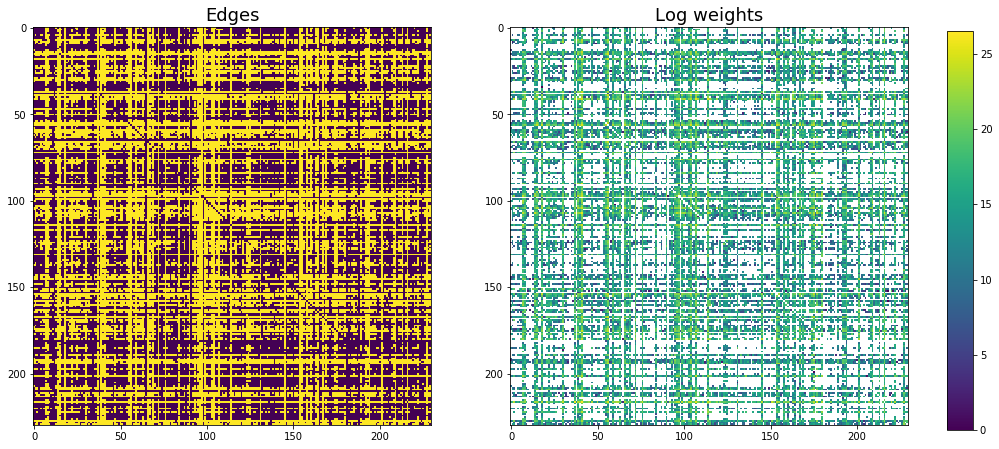

In [4]:
fig, axs = plt.subplots(1,2, figsize=(18,9))
axs[0].set_title('Edges', size=18)
axs[1].set_title('Log weights', size=18)
axs[0].imshow(A_edges.numpy(), cmap='viridis')
ax = axs[1].imshow(A.log().numpy(), cmap='viridis')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.188, 0.02, 0.615])
fig.colorbar(ax, cax=cbar_ax, aspect=30)
#plt.savefig('../examples/images/wt_A_orig.pdf')
plt.show()

## WSBM

We start the WSBM. Again, we assume that there is no more than 12 classes.

In [5]:
num_classes = 12
dataloader = DataLoader(EdgesDataset(A), batch_size=N*4, shuffle=True, num_workers=0)
vi = VI_WSBM(num_nodes=N, num_classes=num_classes)

In [6]:
vi.multi_train(dataloader, epochs=30, lrs = [0.1, 0.05, 0.01], trials=50)

>>>>>>> Start multi-training...
>>> Trial 1/50 | Final loss: 446573.06 | Trial time 140.88
>>> Trial 2/50 | Final loss: 443158.28 | Trial time 148.08
>>> Trial 3/50 | Final loss: 443690.41 | Trial time 102.35
>>> Trial 4/50 | Final loss: 443100.22 | Trial time 99.30
>>> Trial 5/50 | Final loss: 442966.22 | Trial time 88.04
>>> Trial 6/50 | Final loss: 442432.94 | Trial time 92.92
>>> Trial 7/50 | Final loss: 443199.22 | Trial time 107.31
>>> Trial 8/50 | Final loss: 442945.97 | Trial time 145.05
>>> Trial 9/50 | Final loss: 442976.81 | Trial time 95.66
>>> Trial 10/50 | Final loss: 443140.34 | Trial time 105.40
>>> Trial 11/50 | Final loss: 443454.62 | Trial time 91.94
>>> Trial 12/50 | Final loss: 443129.72 | Trial time 140.65
>>> Trial 13/50 | Final loss: 443211.88 | Trial time 152.92
>>> Trial 14/50 | Final loss: 443729.09 | Trial time 152.70
>>> Trial 15/50 | Final loss: 444716.34 | Trial time 126.73
>>> Trial 16/50 | Final loss: 443143.62 | Trial time 117.58
>>> Trial 17/50 | Fina

In [7]:
best_5 = vi.get_multi_losses()[:,-1].argsort()[:5]  

In [8]:
print('The lowest losses:', vi.get_multi_losses()[best_5,-1].numpy())

The lowest losses: [441767.56 442432.94 442487.22 442496.78 442652.06]


In [9]:
print('The number of classes in best trials:', 
      [len(vi.multi_results[0][i].argmax(dim=0).unique()) for i in best_5])

The number of classes in best trials: [6, 5, 5, 5, 5]


The best fits have 5 or 6 classes. Further, we look closely at the trial with the lowest loss.

In [10]:
class_sizes = lambda classes: np.array(pd.Series(classes.numpy()).value_counts().sort_index())

In [11]:
def permute_by_degree(classes, A, dim=0):
    '''Permutate class names by the average node degree,
    so the produced class 0 has the lowest average degree.'''
    df_degree = pd.DataFrame(torch.stack((A.sum(dim=dim), classes)).t().numpy(), columns=['degree', 'class'])
    perm = np.array(df_degree.groupby(['class']).mean()).squeeze().argsort()
    output = torch.zeros(classes.size())
    uni = classes.unique().clone()
    for i in range(len(perm)):
        output = torch.where(classes==uni[perm[i]], 
                            torch.ones(classes.size())*i,
                            output)
    return output, perm

In [12]:
sns.reset_orig()

In [13]:
vi.load_state_dict(vi.state_dicts[best_5[0]])
q_eta, q_theta, q_B, q_w_mu, q_w_tau = vi.constrained_params()

In [14]:
classes = q_eta.argmax(dim=0).float()

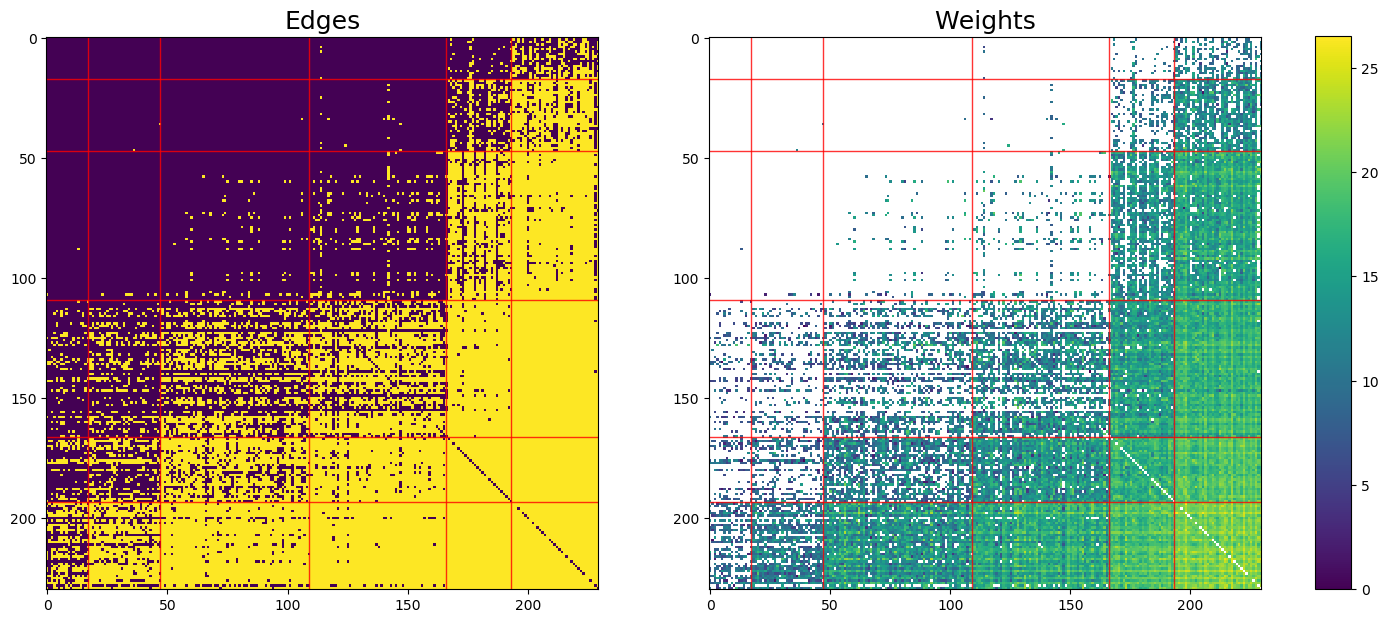

In [15]:
# Sort classes by the average in-weight/import (dim=0)
classes, perm = permute_by_degree(classes, A, 0)
order = classes.argsort()
cs = class_sizes(classes)
fig, axs = plt.subplots(1,2, figsize=(18,9))
axs[0].set_title('Edges', size=18)
axs[1].set_title('Weights', size=18)
axs[0].imshow(A_edges[order,:][:,order].numpy(), cmap='viridis')
acc = -1
for i in cs[:-1]:
    acc += i
    axs[0].axvline(acc, color='r', linestyle='-', linewidth=1, alpha=0.8)
    axs[0].axhline(acc, color='r', linestyle='-', linewidth=1, alpha=0.8)
ax = axs[1].imshow(A.log()[order,:][:,order].numpy(), cmap='viridis')
acc = -1
for i in cs[:-1]:
    acc += i
    axs[1].axvline(acc, color='r', linestyle='-', linewidth=1, alpha=0.8)
    axs[1].axhline(acc, color='r', linestyle='-', linewidth=1, alpha=0.8)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.188, 0.02, 0.615])
fig.colorbar(ax, cax=cbar_ax, aspect=30)
#plt.savefig('../examples/images/wt_A_wsbm.pdf')
plt.show()


In [16]:
print('Total #countries:', len(countries_id))
for i in classes.unique().sort().values:
    g = countries_id[classes==i]
    #g.sort()
    print('Class %d (%d countries):' % (i, len(g)))
    print(g)

Total #countries: 230
Class 0 (18 countries):
['ata' 'atf' 'bvt' 'cck' 'cxr' 'esh' 'hmd' 'iot' 'mnp' 'msr' 'nfk' 'niu'
 'pcn' 'plw' 'sgs' 'spm' 'tuv' 'wlf']
Class 1 (30 countries):
['aia' 'asm' 'btn' 'cok' 'com' 'eri' 'flk' 'fsm' 'gnb' 'grd' 'grl' 'gum'
 'kir' 'kna' 'lca' 'lso' 'myt' 'nru' 'shn' 'slb' 'som' 'stp' 'tca' 'tkl'
 'tls' 'ton' 'umi' 'vat' 'vut' 'wsm']
Class 2 (62 countries):
['abw' 'afg' 'ago' 'and' 'ant' 'atg' 'bdi' 'ben' 'bfa' 'bhs' 'blz' 'bmu'
 'brb' 'brn' 'bwa' 'caf' 'cod' 'cog' 'cpv' 'cub' 'cym' 'dji' 'dma' 'fro'
 'gab' 'gib' 'gin' 'gmb' 'gnq' 'guy' 'hnd' 'hti' 'irq' 'lao' 'lbr' 'lby'
 'mdv' 'mhl' 'mkd' 'mli' 'mng' 'mrt' 'nam' 'ner' 'png' 'prk' 'pse' 'rwa'
 'sdn' 'sle' 'smr' 'sur' 'swz' 'syc' 'tcd' 'tgo' 'tjk' 'tkm' 'uzb' 'vct'
 'vgb' 'yem']
Class 3 (57 countries):
['alb' 'arm' 'aze' 'bgd' 'bhr' 'bih' 'blr' 'bol' 'civ' 'cmr' 'cri' 'cyp'
 'dom' 'dza' 'ecu' 'eth' 'fji' 'geo' 'gha' 'gtm' 'isl' 'jam' 'jor' 'kaz'
 'ken' 'kgz' 'khm' 'kwt' 'lbn' 'mac' 'mda' 'mdg' 'mlt' 'mmr' '

Now, we plot the obtained class assignments on the worlds map with `folium` (black is for unavailable data).

In [17]:
import folium
world_json_path = '../data/World trade/world-countries.json'
countries_id = np.array(df.columns)
for c in range(len(countries_id)):
    countries_id[c] = countries_id[c].upper()
df_map = pd.DataFrame({'code':countries_id, 'val':classes.numpy()})
m = folium.Map(location=[0,0], zoom_start=2)

folium.Choropleth(
    geo_data=world_json_path,
    name='choropleth',
    data=df_map,
    columns=['code', 'val'],
    key_on='feature.id',
    fill_color='RdPu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Classes',
    #bins=[0.,1.,2.,3.,4.,5.]
    bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5]
).add_to(m)

folium.LayerControl().add_to(m)

m

Again, we examine the distributions of $\theta$ and $B$.

In [18]:
nonempty_classes = q_eta.detach().argmax(dim=0).unique()[perm]
num_ne = len(nonempty_classes)

In [19]:
q_theta_nonempty = q_theta.detach()[nonempty_classes]
num_samples = 1000
theta_samples = Dirichlet(q_theta_nonempty).sample([num_samples])

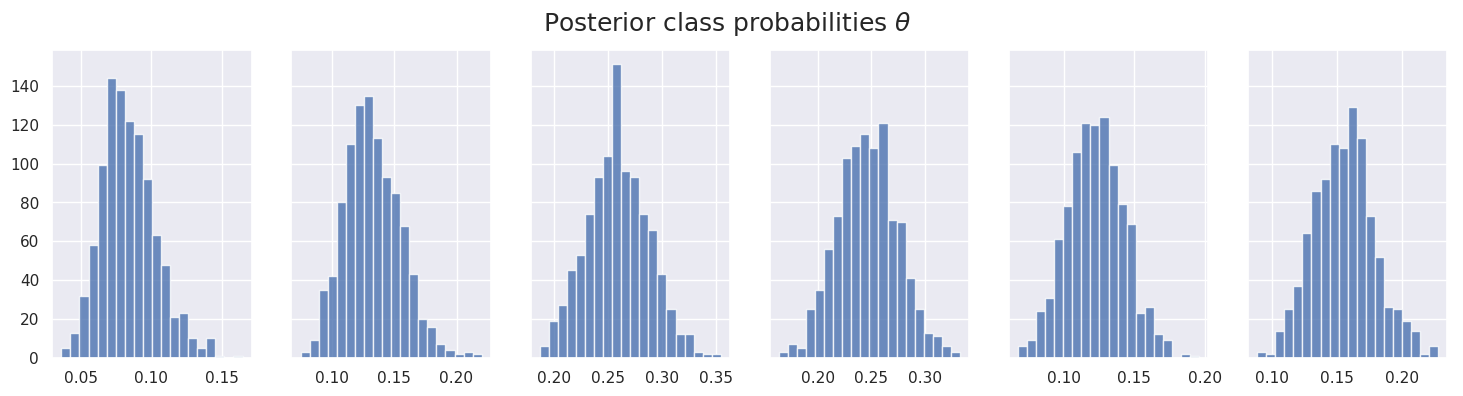

In [20]:
sns.set()
fig, axs = plt.subplots(1, num_ne, figsize=(18, 4), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_ne):
    axs[i].hist(theta_samples[:,i], bins=bins, alpha=alpha) 
fig.suptitle(r'Posterior class probabilities $\theta$', fontsize=18)
#plt.savefig('../examples/images/wt_thetas_wsbm.pdf')
plt.show()

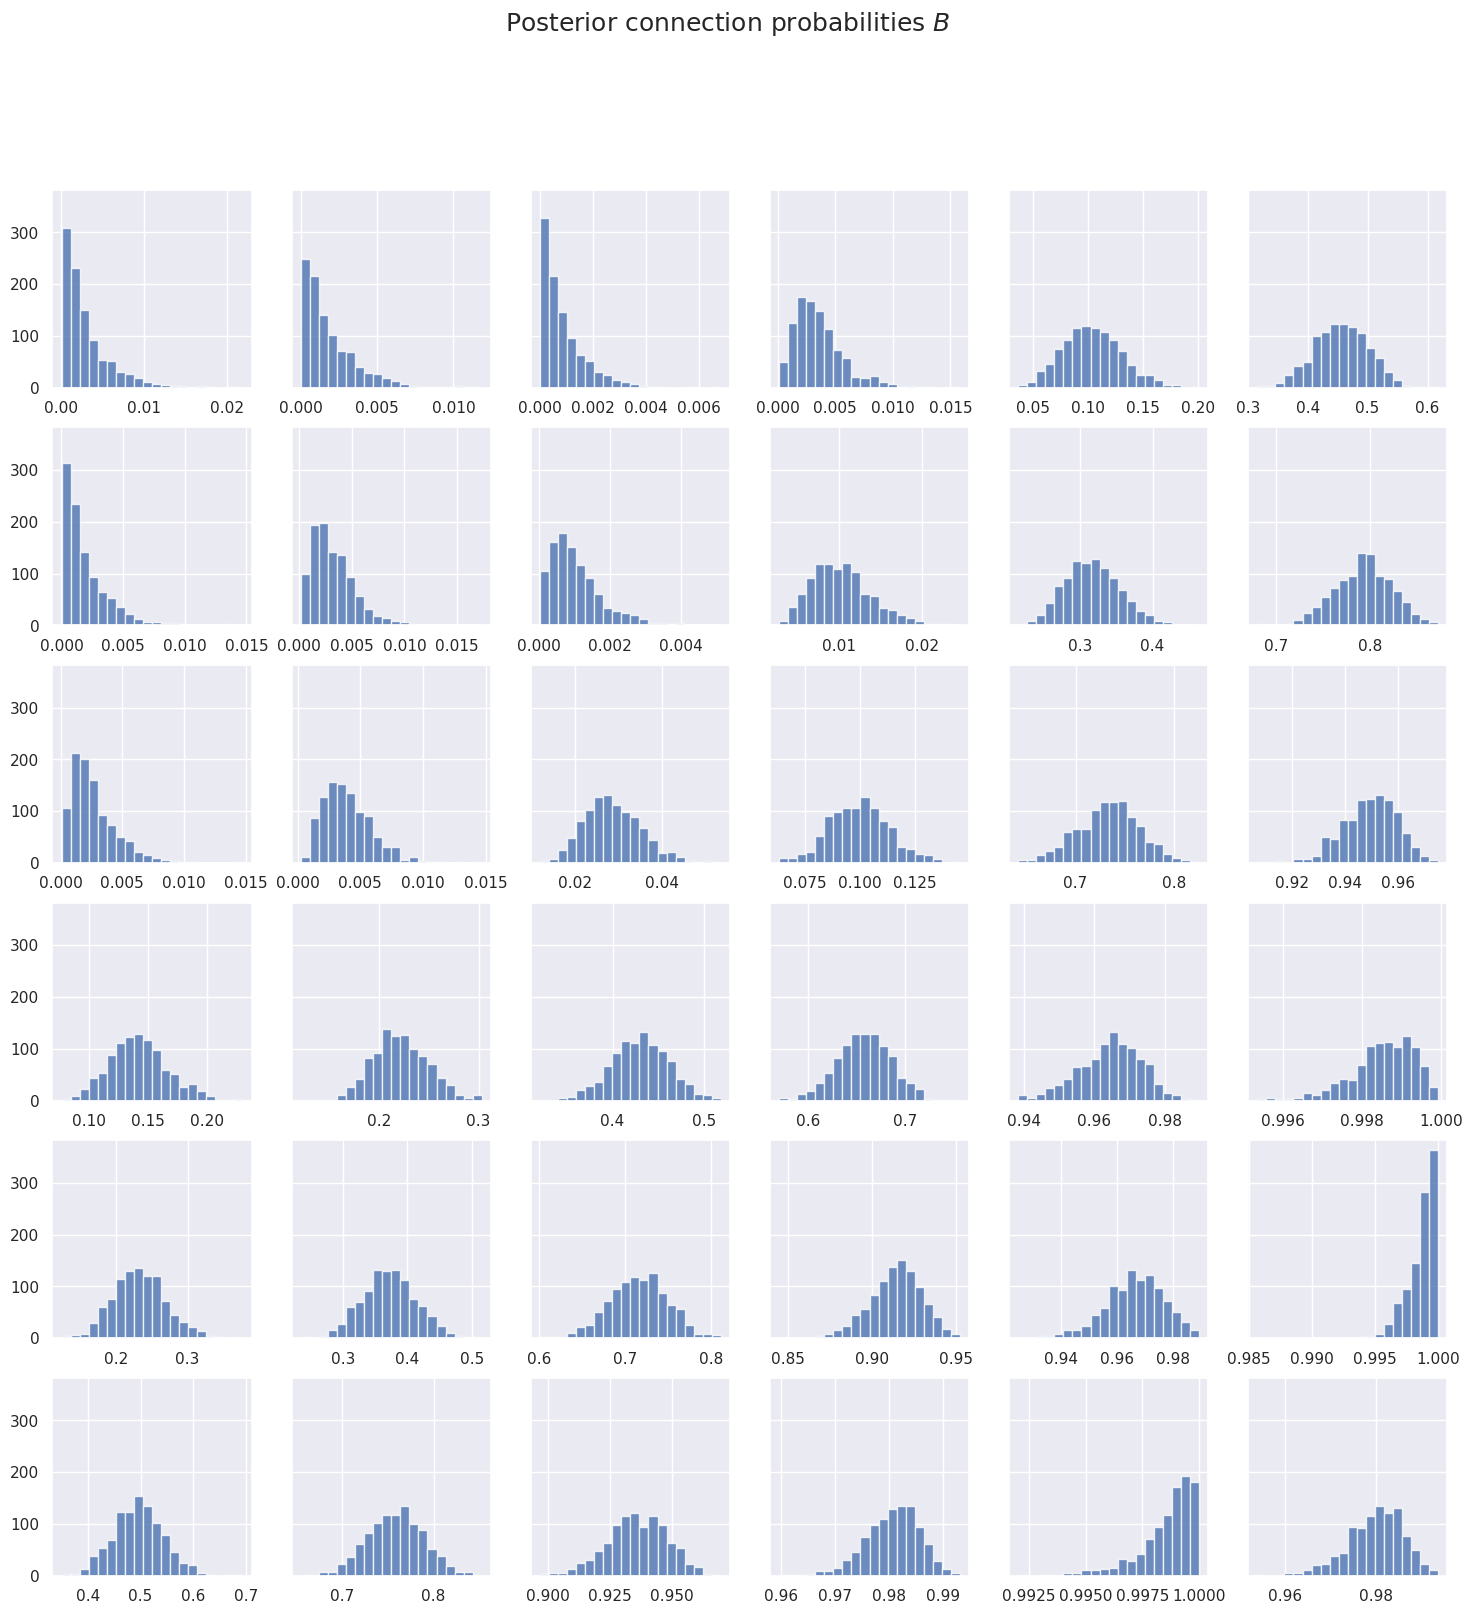

In [21]:
q_B_nonempty = q_B.detach()[nonempty_classes,:,:][:,nonempty_classes,:]
B_samples = Beta(q_B_nonempty[:,:,0], q_B_nonempty[:,:,1]).sample([num_samples])

fig, axs = plt.subplots(num_ne, num_ne, figsize=(18,18), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_ne):
    for j in range(num_ne):
        axs[i,j].hist(B_samples[:,i, j], bins=bins, alpha=alpha) 
fig.suptitle(r'Posterior connection probabilities $B$', fontsize=18)
#plt.savefig('../examples/images/wt_B_wsbm.pdf')
plt.show()

Next, we look at the weight distributions. We sample weights from the estimated means of $q(w_{\mu})$ and $q(w_{\tau})$ and plot them together with the real weights of edges between the obtained classes. Here, we also show the log weights for visual clarity.

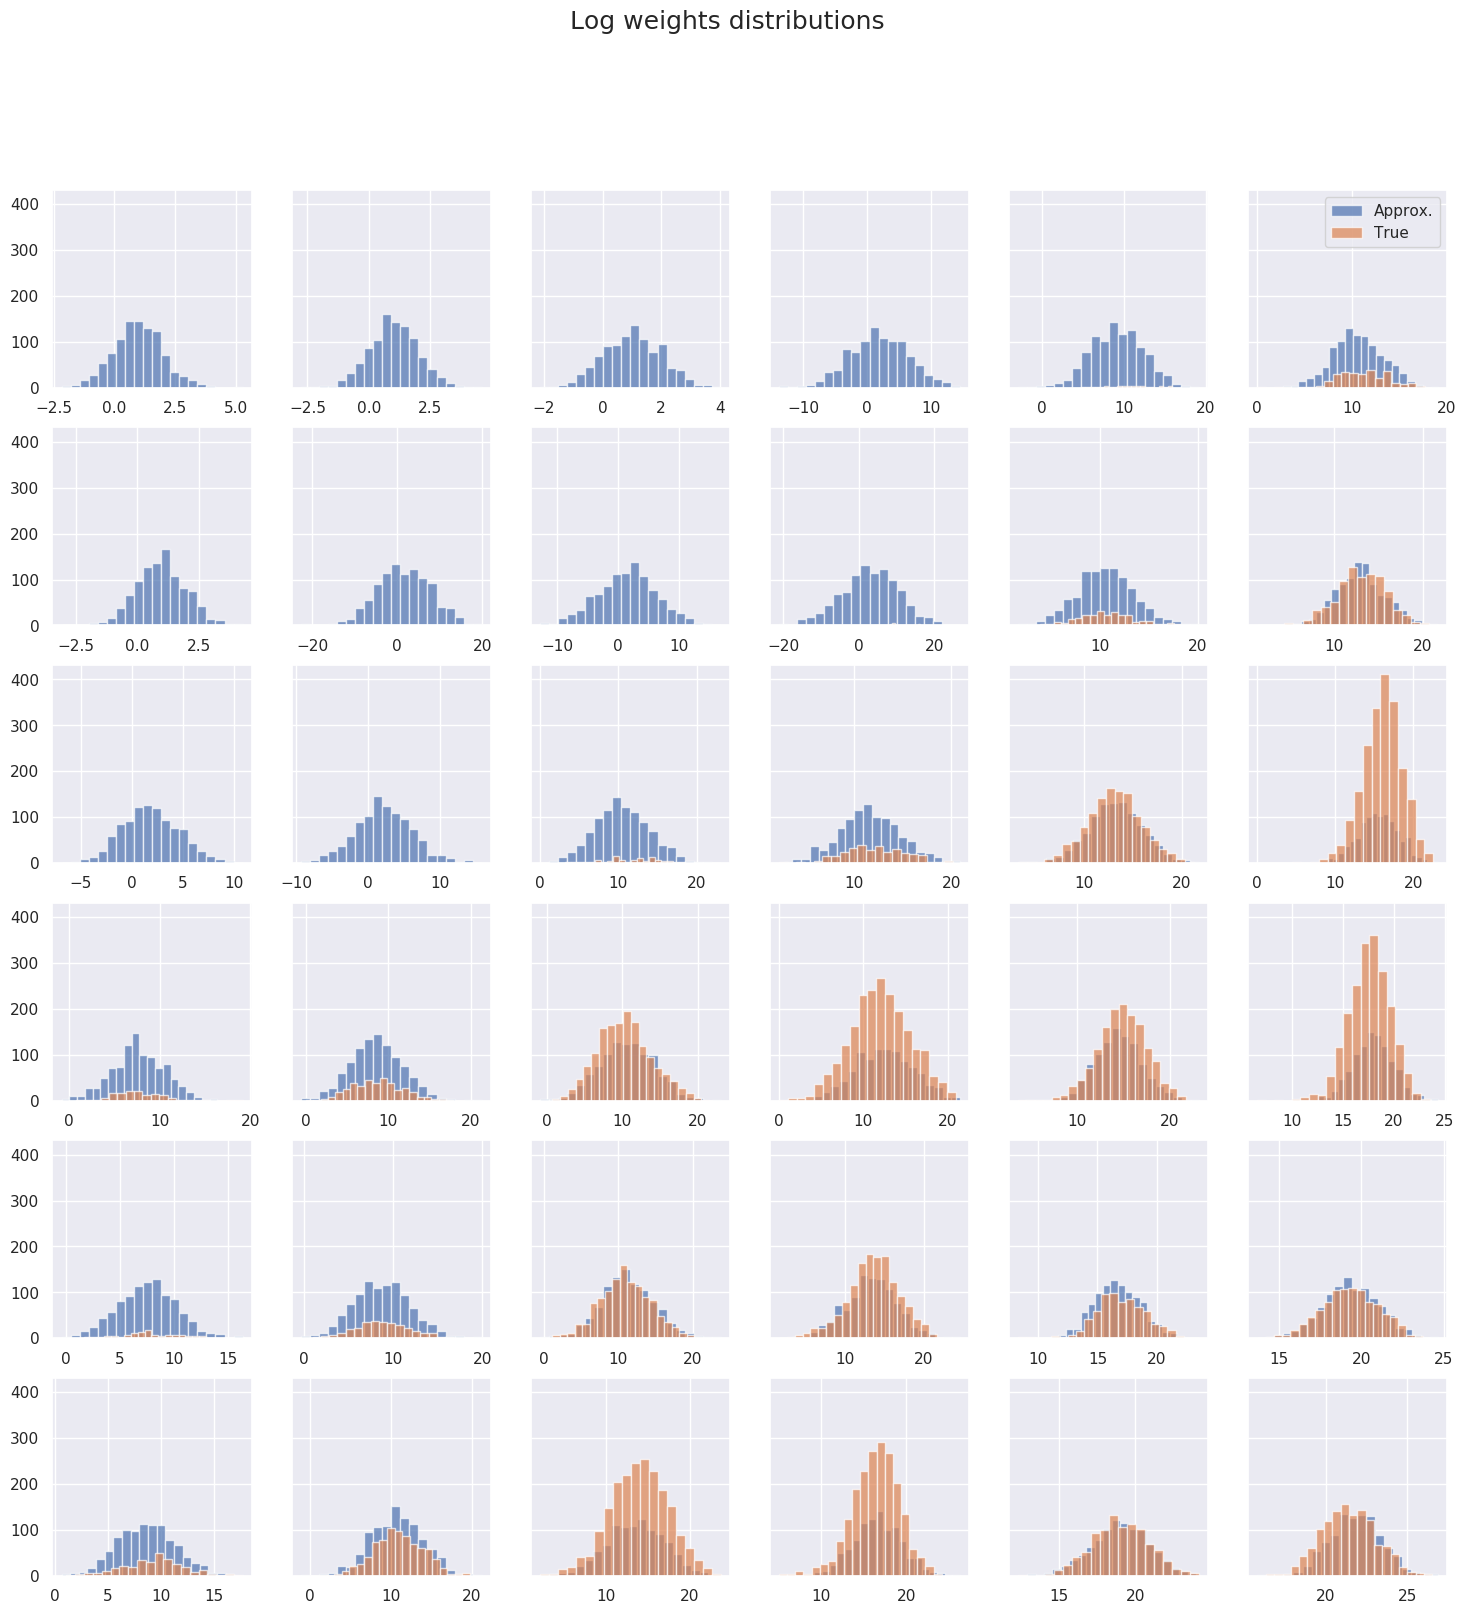

In [22]:
_,_,_, q_w_mu_mean, q_w_tau_mean = vi.qmean()    # Get the parameter means

from torch.distributions.log_normal import LogNormal
q_w_mu_mean_perm = q_w_mu_mean.detach()[nonempty_classes,:][:,nonempty_classes]
q_w_tau_mean_perm = q_w_tau_mean.detach()[nonempty_classes,:][:,nonempty_classes]
q_w_samples = LogNormal(q_w_mu_mean_perm, 1/q_w_tau_mean_perm.sqrt()).sample([num_samples]).log()
fig, axs = plt.subplots(num_ne, num_ne, figsize=(18,18), sharey=True)

bins, alpha = 20, 0.7
for i in range(num_ne):
    for j in range(num_ne):
        axs[i,j].hist(q_w_samples[:,i, j], bins=bins, alpha=alpha, label='Approx.')
        A_ = A[classes==i,:][:,classes==j]
        x = A_[A_>0].flatten().log()
        if x.sum()>0:
            axs[i,j].hist(x, bins=bins, alpha=alpha, label='True')         
fig.suptitle(r'Log weights distributions', fontsize=18)
axs[0,5].legend()
#plt.savefig('../examples/images/wt_w_wsbm.pdf')
plt.show()

The approximated and observed distributions looks similar. However, we use [Q-Q plots](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) to check how close the data's distribution to the assumed Log-Normal distribution.

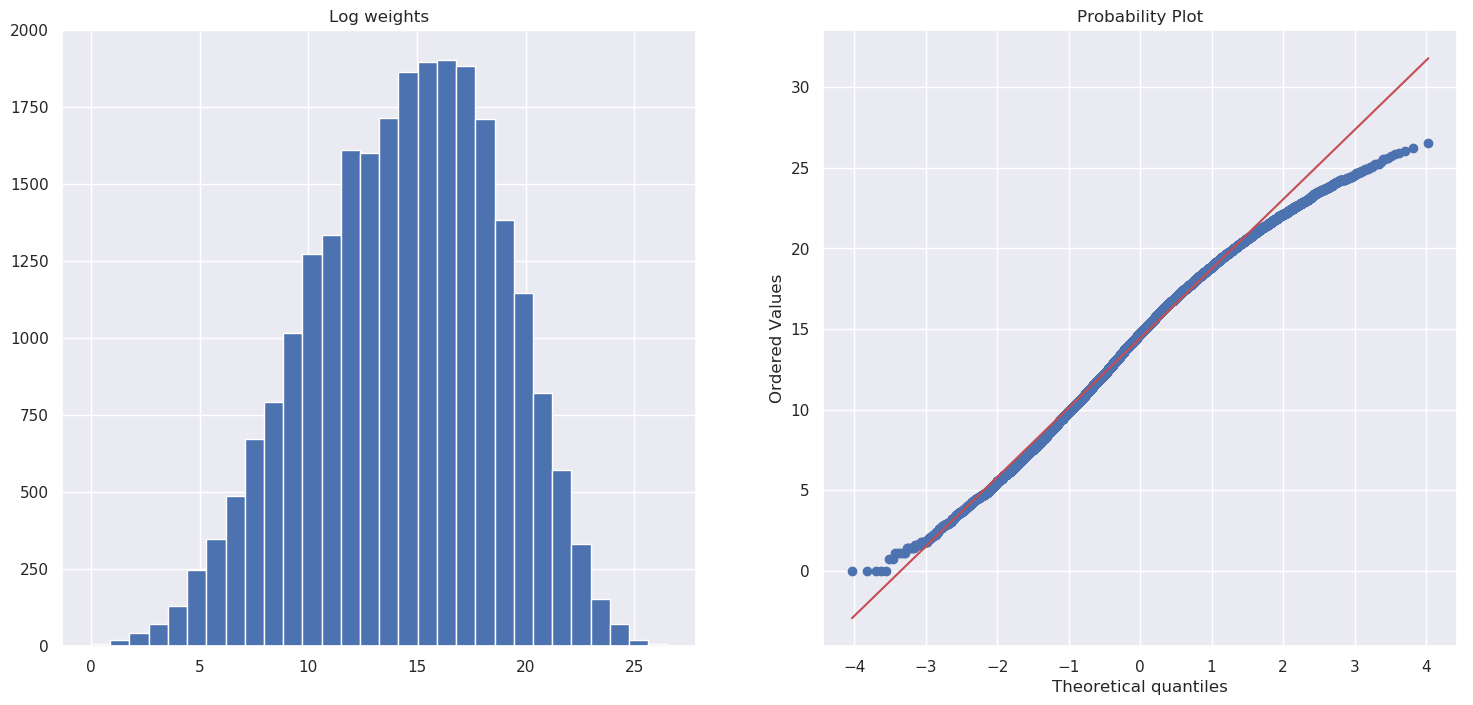

In [23]:
import scipy.stats as stats
sns.set()
fig, axs = plt.subplots(1,2, figsize=(18,8))
axs[0].hist((A[A>0]).flatten().log(), bins=30)
axs[0].set_title('Log weights', size=12)
stats.probplot(A[A>0].flatten().log(), dist="norm", plot=axs[1])
plt.savefig('../examples/images/wt_probplot_1class.pdf')
plt.show()

We see that both tails of the weight distribution differ from the Log-Normal if we consider that all nodes belong only to one class. Next, we investigate it for the WSBM's class assingnment.

 /home/mo/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning:invalid value encountered in double_scalars 
 /home/mo/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning:invalid value encountered in sqrt 
 /home/mo/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning:invalid value encountered in double_scalars 


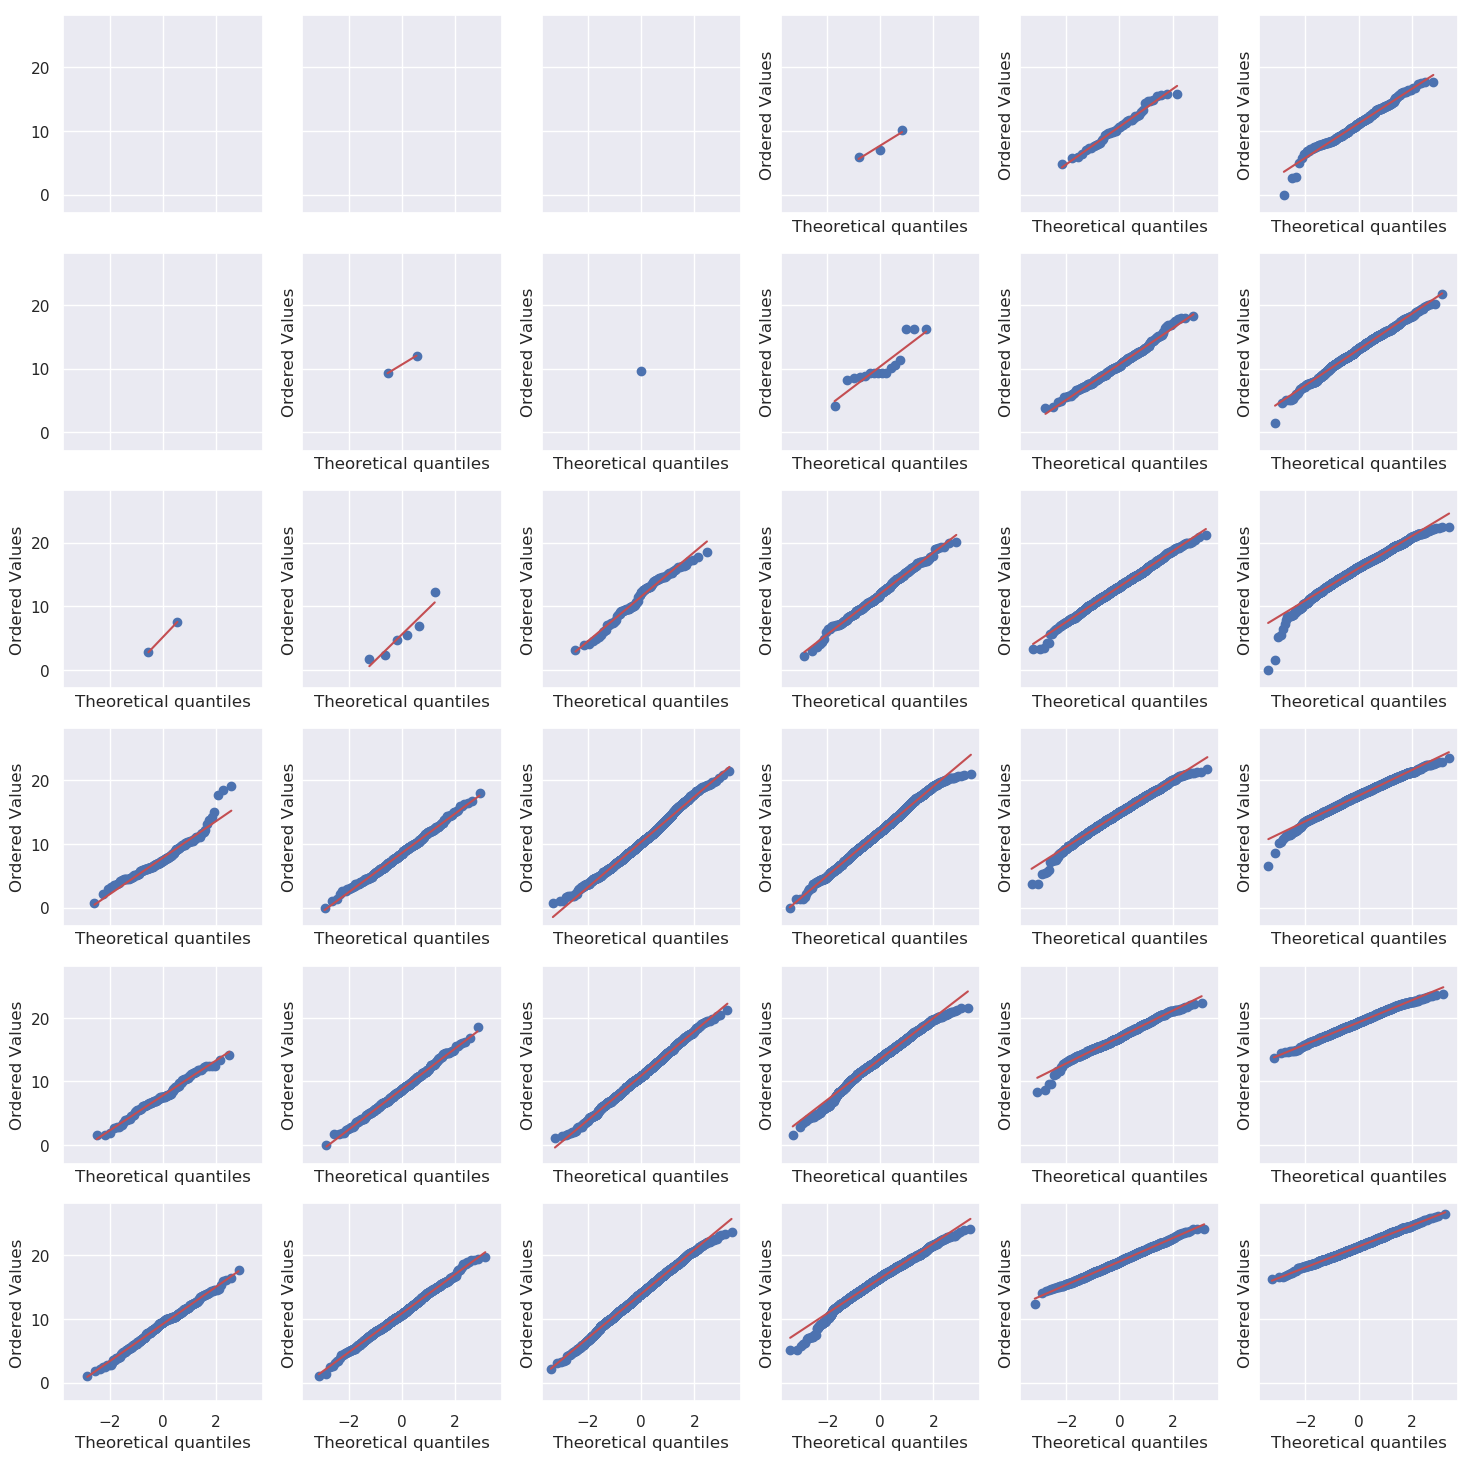

In [24]:
fig, axs = plt.subplots(num_ne, num_ne, figsize=(18,18), sharey=True, sharex=True)
for i in range(num_ne):
    for j in range(num_ne):
        A_ = A[classes==i,:][:,classes==j]
        #axs[i,j] = fig.add_subplot(num_ne, num_ne, 1+i*num_ne+j)
        x = A_[A_>0].flatten().log()
        if x.sum()>0:
            stats.probplot(x, dist="norm", plot=axs[i,j])
            axs[i,j].set_title('')
#plt.savefig('../examples/images/wt_probplot_wsbm.pdf')
plt.show()

This collection of distributions is not ideal but it looks better then just one.

## WDCSBM

We assume that the standard SBM divides nodes into groups mostly based on their in- and out-degree. Now, let us add degree-correction to other possible patterns. As befor we initialize $\delta$ with the observed degree distributions.

In [25]:
delta_init = torch.ones([N,2])
delta_mu = A_edges.sum(dim=1)/A_edges.sum(dim=1).mean()
delta_init[:,0]=delta_mu.log().clone()
print('Contains infinities:', bool(torch.isinf(delta_init).sum().item()))

Contains infinities: False


In [26]:
dataloader = DataLoader(EdgesDataset(A), batch_size=N*4, shuffle=True, num_workers=0)

vi = VI_WDCSBM(num_nodes=N, num_classes=num_classes,
                   init_values={'etas':None, 
                              'thetas':None, 
                              'Bs':None, 
                              'deltas':delta_init,
                              'mus':None,
                              'taus':None})
vi.multi_train(dataloader, epochs=30, lrs = [0.1, 0.05, 0.01], trials=50)

>>>>>>> Start multi-training...
>>> Trial 1/50 | Final loss: 439968.75 | Trial time 222.67
>>> Trial 2/50 | Final loss: 440739.06 | Trial time 236.08
>>> Trial 3/50 | Final loss: 441524.78 | Trial time 389.07
>>> Trial 4/50 | Final loss: 444049.22 | Trial time 333.83
>>> Trial 5/50 | Final loss: 440400.28 | Trial time 307.11
>>> Trial 6/50 | Final loss: 441564.94 | Trial time 356.83
>>> Trial 7/50 | Final loss: 444301.19 | Trial time 356.90
>>> Trial 8/50 | Final loss: 441567.41 | Trial time 354.69
>>> Trial 9/50 | Final loss: 440576.94 | Trial time 352.30
>>> Trial 10/50 | Final loss: 440614.72 | Trial time 355.76
>>> Trial 11/50 | Final loss: 442671.69 | Trial time 354.02
>>> Trial 12/50 | Final loss: 442044.19 | Trial time 359.86
>>> Trial 13/50 | Final loss: 440527.22 | Trial time 360.28
>>> Trial 14/50 | Final loss: 440515.88 | Trial time 307.79
>>> Trial 15/50 | Final loss: 443788.50 | Trial time 362.05
>>> Trial 16/50 | Final loss: 442327.91 | Trial time 366.92
>>> Trial 17/50 |

Let us examine five best trials.

In [27]:
best_5 = vi.get_multi_losses()[:,-1].argsort()[:5]  

In [28]:
print('The lowest losses:', vi.get_multi_losses()[best_5,-1].numpy())

The lowest losses: [439297.62 439618.4  439968.75 440166.   440208.53]


In [29]:
print('The number of classes in best trials:', 
      [len(vi.multi_results[0][i].argmax(dim=0).unique()) for i in best_5])

The number of classes in best trials: [4, 4, 4, 4, 4]


Again, the model with degree-correction can achieve the smaller losses.

In [30]:
vi.load_state_dict(vi.state_dicts[best_5[0]])
q_eta, q_theta, q_B, q_delta, q_w_mu, q_w_tau = vi.constrained_params()

In [31]:
sns.reset_orig()

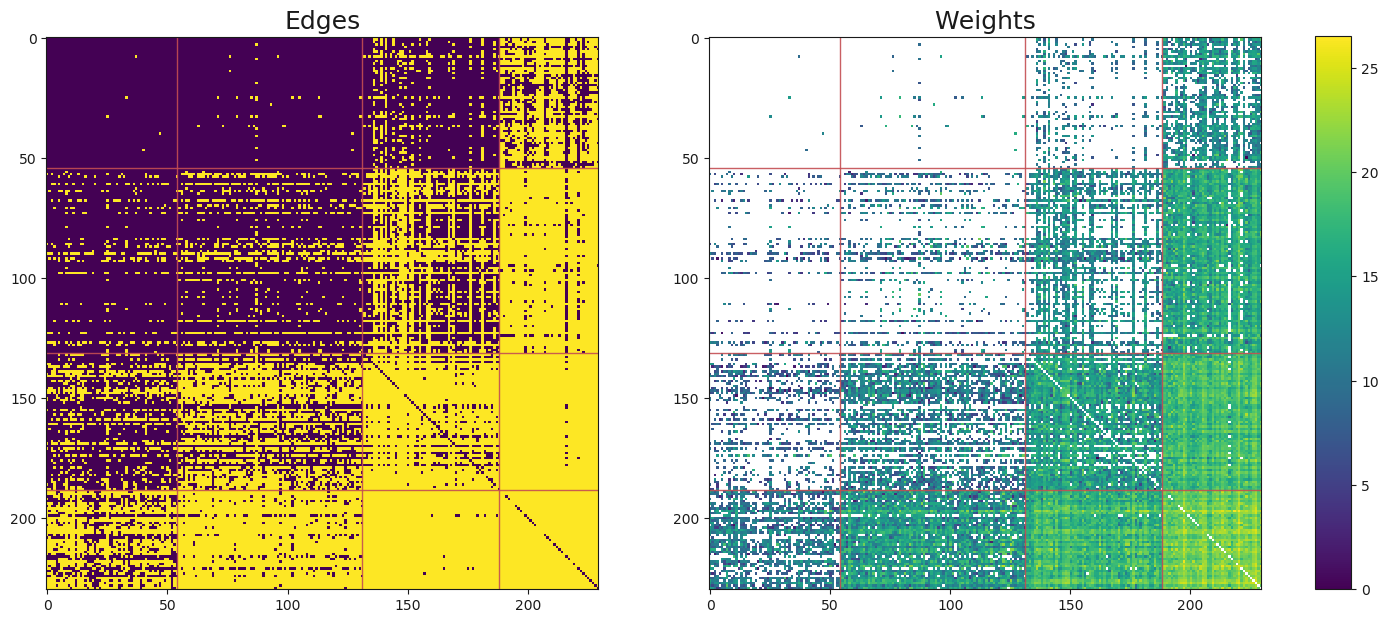

In [32]:
# Sort classes by the average in-weight/import (dim=0)
classes = q_eta.argmax(dim=0).float()
classes, perm = permute_by_degree(classes, A, 0)
order = classes.argsort()
cs = class_sizes(classes)
fig, axs = plt.subplots(1,2, figsize=(18,9))
axs[0].set_title('Edges', size=18)
axs[1].set_title('Weights', size=18)
axs[0].imshow(A_edges[order,:][:,order].numpy(), cmap='viridis')
acc = -1
for i in cs[:-1]:
    acc += i
    axs[0].axvline(acc, color='r', linestyle='-', linewidth=1, alpha=0.9)
    axs[0].axhline(acc, color='r', linestyle='-', linewidth=1, alpha=0.9)
ax = axs[1].imshow(A.log()[order,:][:,order].numpy(), cmap='viridis')
acc = -1
for i in cs[:-1]:
    acc += i
    axs[1].axvline(acc, color='r', linestyle='-', linewidth=1, alpha=0.9)
    axs[1].axhline(acc, color='r', linestyle='-', linewidth=1, alpha=0.9)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.188, 0.02, 0.615])
fig.colorbar(ax, cax=cbar_ax, aspect=30)
#plt.savefig('../examples/images/wt_A_wdcsbm.pdf')
plt.show()


In [33]:
print('Total #countries:', len(countries_id))
for i in classes.unique().sort().values:
    g = countries_id[classes==i]
    print('Class %d (%d countries):' % (i, len(g)))
    print(g)

Total #countries: 230
Class 0 (55 countries):
['AIA' 'AND' 'ASM' 'ATA' 'ATF' 'BDI' 'BTN' 'BVT' 'CAF' 'CCK' 'COK' 'COM'
 'CXR' 'DMA' 'ERI' 'ESH' 'FLK' 'FSM' 'GMB' 'GNB' 'GRD' 'GRL' 'GUM' 'HMD'
 'IOT' 'KIR' 'KNA' 'LCA' 'LSO' 'MNP' 'MSR' 'MYT' 'NFK' 'NIU' 'NRU' 'PCN'
 'PLW' 'SGS' 'SHN' 'SLB' 'SOM' 'SPM' 'STP' 'TCA' 'TCD' 'TKL' 'TLS' 'TON'
 'TUV' 'UMI' 'VAT' 'VCT' 'VUT' 'WLF' 'WSM']
Class 1 (77 countries):
['ABW' 'AFG' 'AGO' 'ALB' 'ANT' 'ARM' 'ATG' 'BEN' 'BFA' 'BHS' 'BLZ' 'BMU'
 'BOL' 'BRB' 'BRN' 'BWA' 'COD' 'COG' 'CPV' 'CYM' 'DJI' 'FJI' 'FRO' 'GAB'
 'GIB' 'GIN' 'GNQ' 'GUY' 'HND' 'HTI' 'IRQ' 'JAM' 'KGZ' 'KHM' 'LAO' 'LBR'
 'MAC' 'MDA' 'MDG' 'MDV' 'MHL' 'MKD' 'MLI' 'MMR' 'MNE' 'MNG' 'MRT' 'MWI'
 'NAM' 'NCL' 'NER' 'NIC' 'NPL' 'PNG' 'PRK' 'PRY' 'PSE' 'PYF' 'RWA' 'SDN'
 'SEN' 'SLE' 'SLV' 'SMR' 'SUR' 'SWZ' 'SYC' 'TGO' 'TJK' 'TKM' 'TTO' 'UGA'
 'UZB' 'VGB' 'YEM' 'ZMB' 'ZWE']
Class 2 (57 countries):
['AZE' 'BGD' 'BGR' 'BHR' 'BIH' 'BLR' 'CHL' 'CIV' 'CMR' 'COL' 'CRI' 'CUB'
 'CYP' 'DOM' 'DZA' 'ECU' 'E

In [34]:
import folium
world_json_path = '../data/World trade/world-countries.json'
countries_id = np.array(df.columns)
for c in range(len(countries_id)):
    countries_id[c] = countries_id[c].upper()
df_map = pd.DataFrame({'code':countries_id, 'val':classes.numpy()})
m = folium.Map(location=[0,0], zoom_start=2)

folium.Choropleth(
    geo_data=world_json_path,
    name='choropleth',
    data=df_map,
    columns=['code', 'val'],
    key_on='feature.id',
    fill_color='RdPu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Classes',
    #bins=[0.,1.,2.,3.,4.,5.]
    bins=[-0.5,0.5,1.5,2.5,3.5]
).add_to(m)

folium.LayerControl().add_to(m)

m

In [35]:
nonempty_classes = q_eta.detach().argmax(dim=0).unique()[perm]
num_ne = len(nonempty_classes)

In [36]:
q_theta_nonempty = q_theta.detach()[nonempty_classes]
num_samples = 1000
theta_samples = Dirichlet(q_theta_nonempty).sample([num_samples])

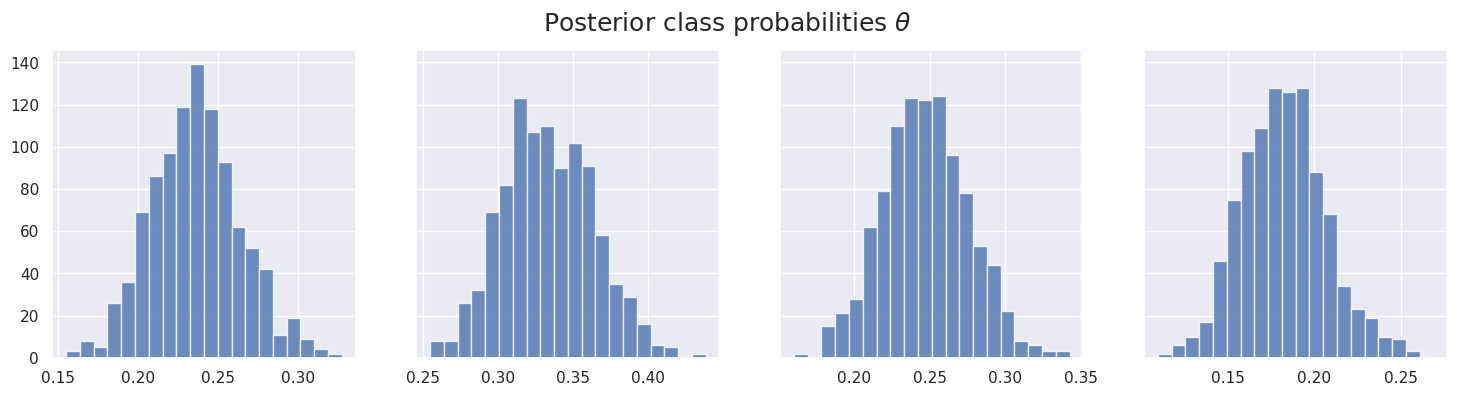

In [37]:
sns.set()
fig, axs = plt.subplots(1, num_ne, figsize=(18,4), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_ne):
    axs[i].hist(theta_samples[:,i], bins=bins, alpha=alpha) 
fig.suptitle(r'Posterior class probabilities $\theta$', fontsize=18)
#plt.savefig('../examples/images/wt_theta_wdcsbm.pdf')
plt.show()

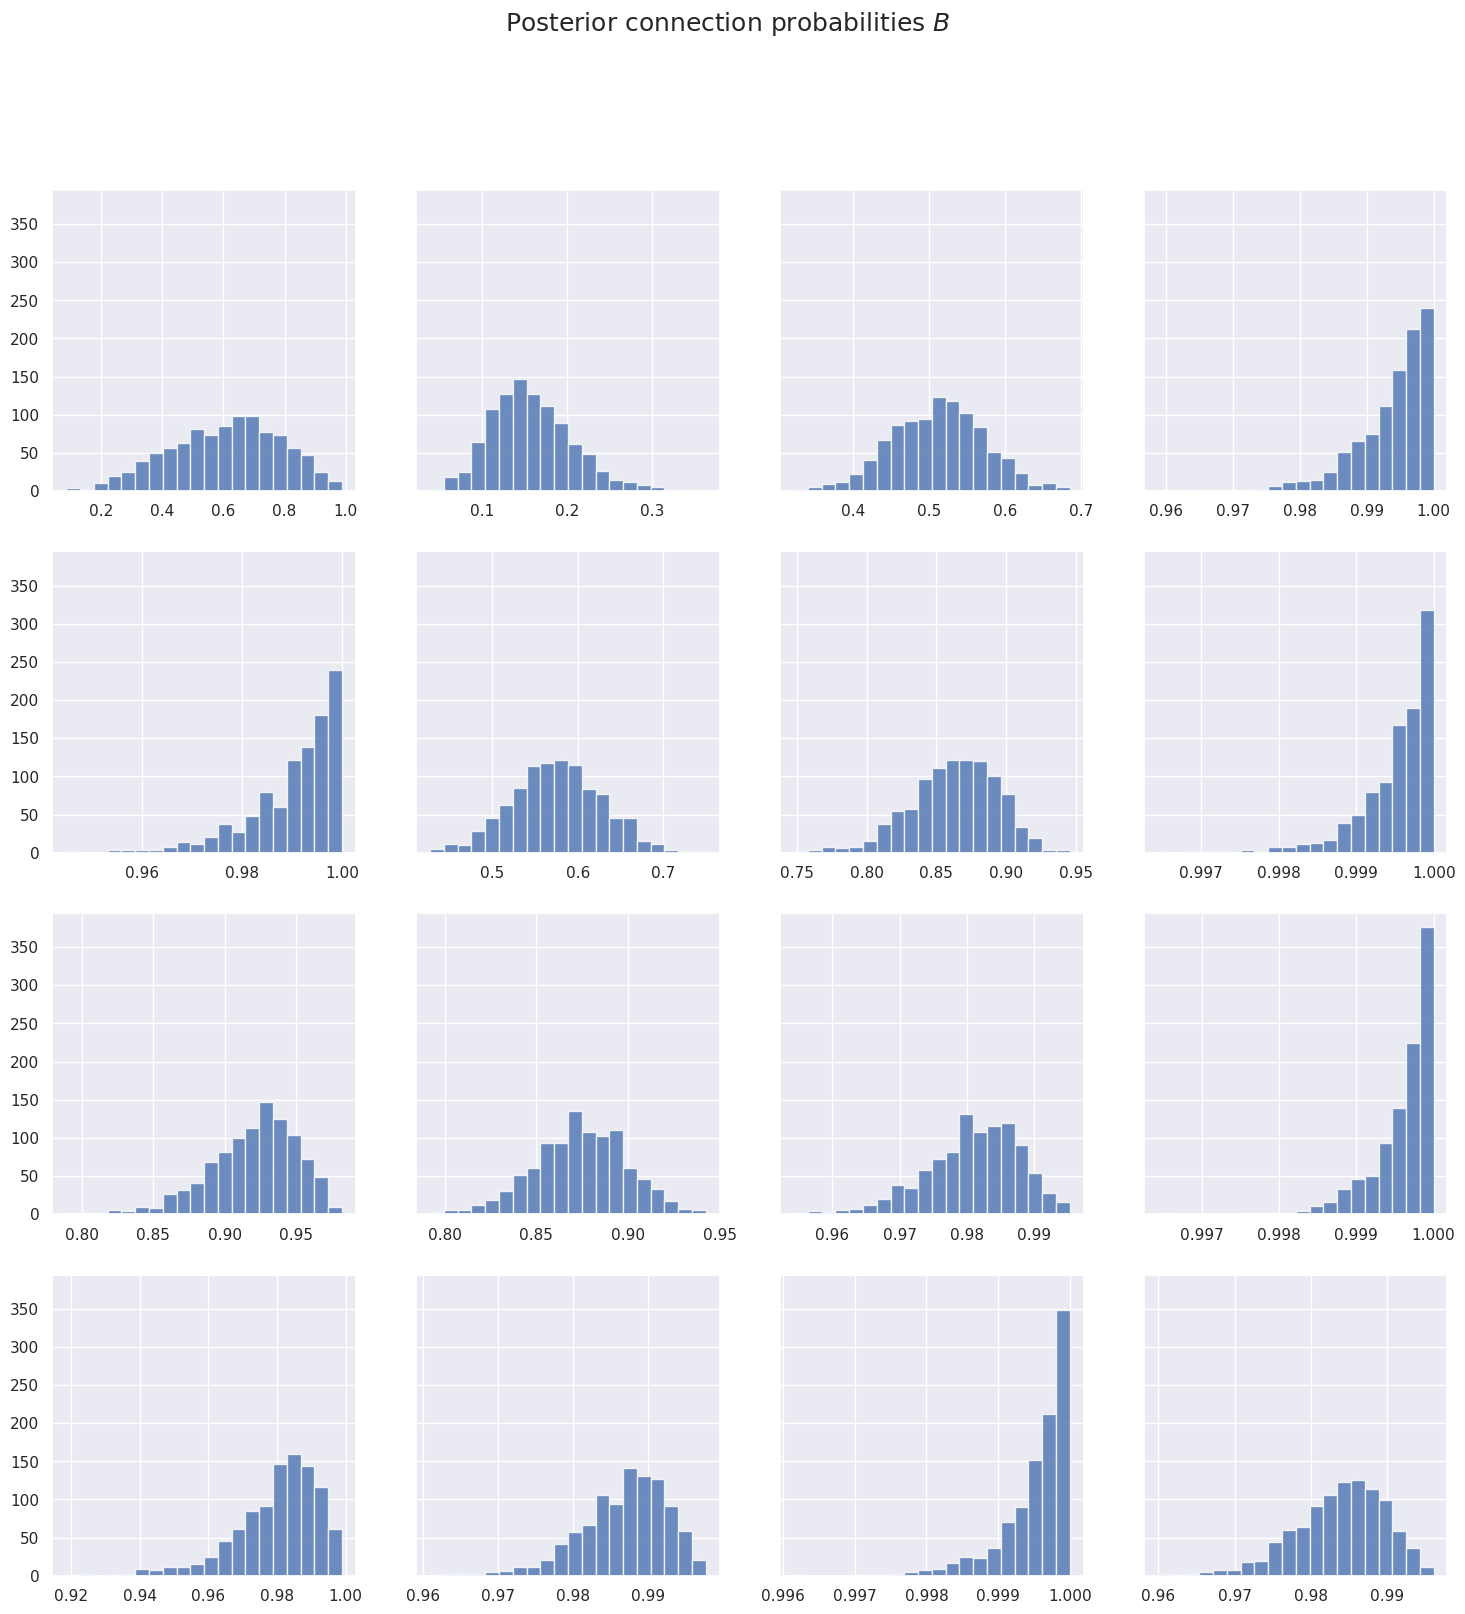

In [38]:
q_B_nonempty = q_B.detach()[nonempty_classes,:,:][:,nonempty_classes,:]
B_samples = Beta(q_B_nonempty[:,:,0], q_B_nonempty[:,:,1]).sample([num_samples])

fig, axs = plt.subplots(num_ne, num_ne, figsize=(18,18), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_ne):
    for j in range(num_ne):
        axs[i,j].hist(B_samples[:,i, j], bins=bins, alpha=alpha) 
fig.suptitle(r'Posterior connection probabilities $B$', fontsize=18)
#plt.savefig('../examples/images/wt_B_wdcsbm.pdf')
plt.show()

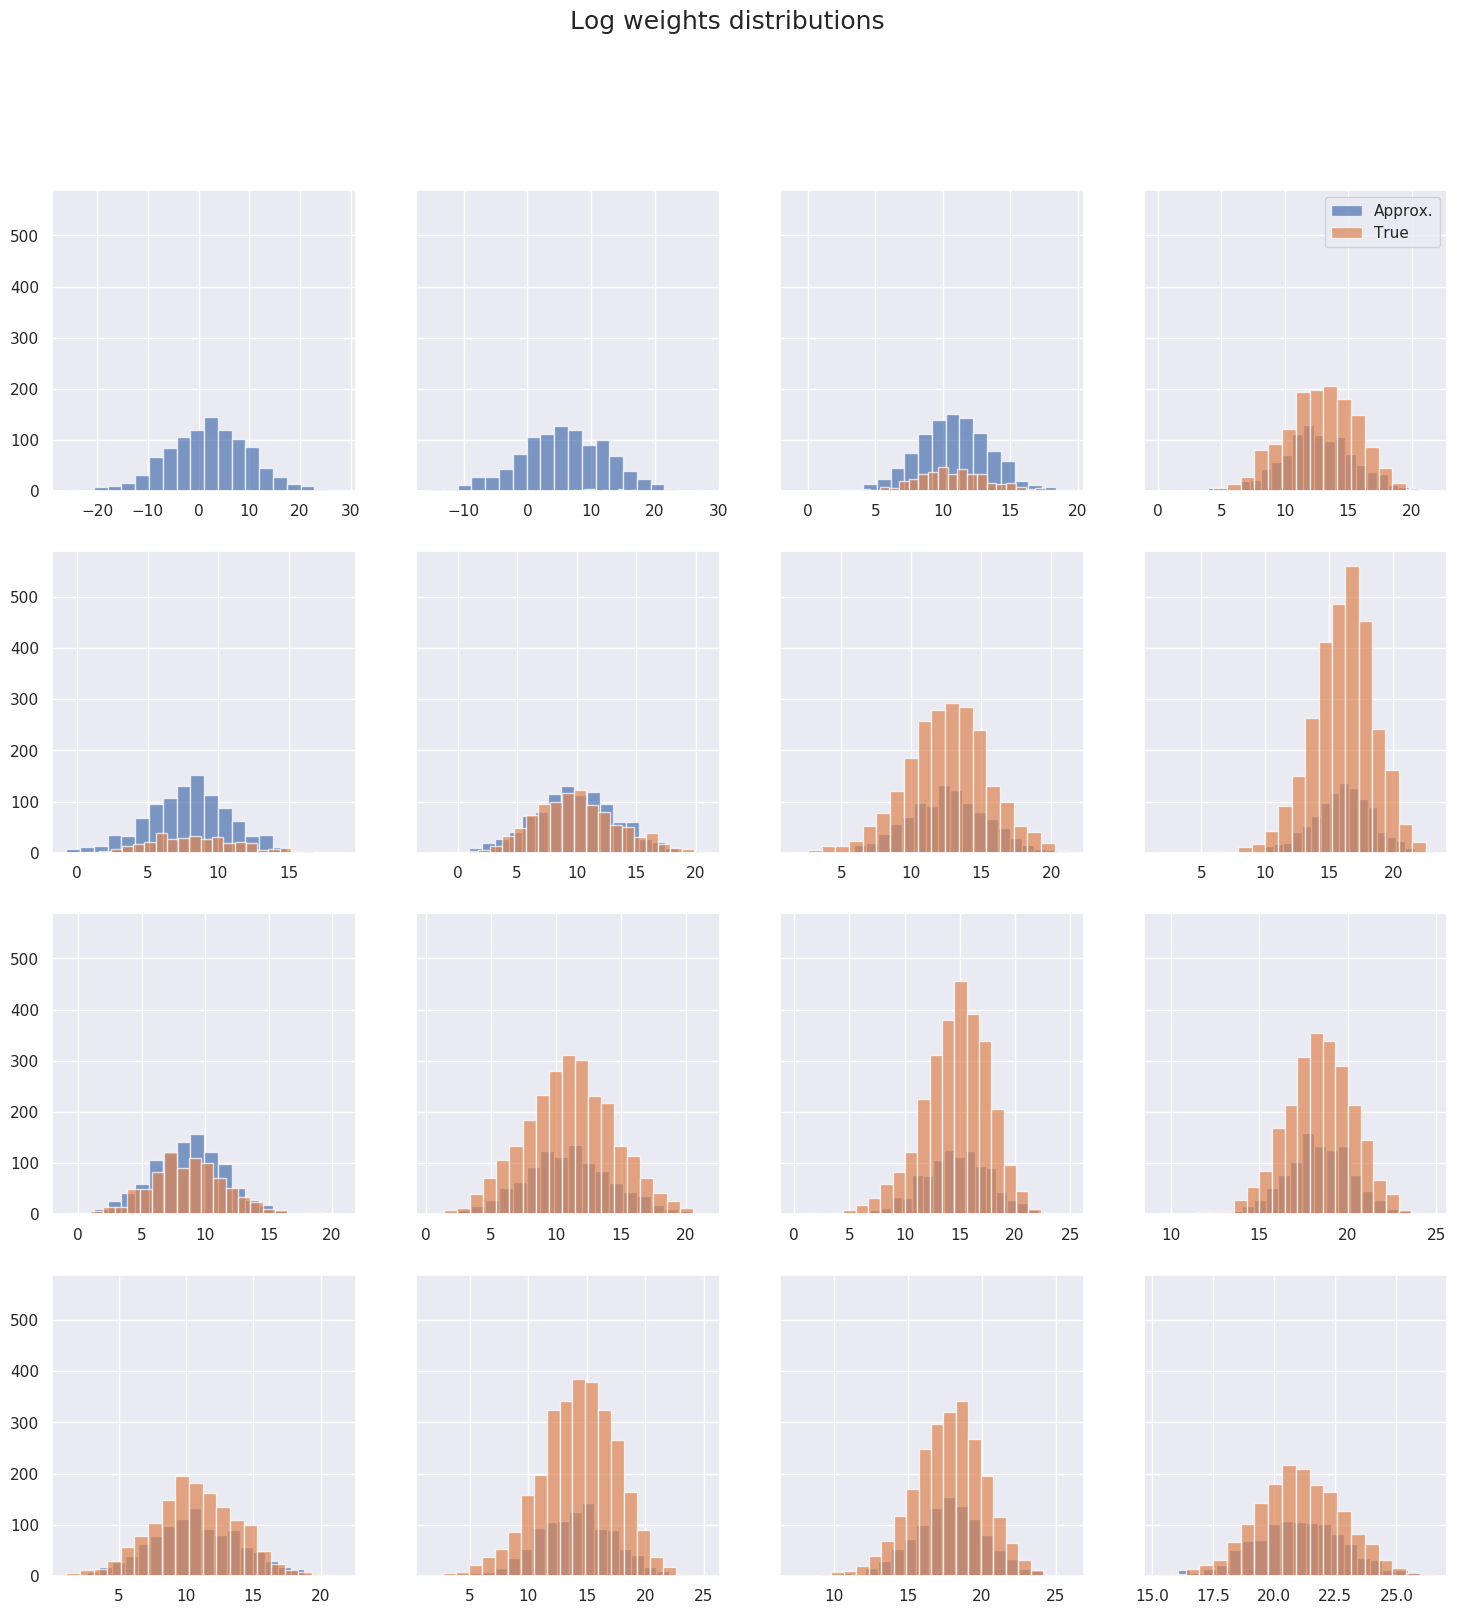

In [42]:
_,_,_,_, q_w_mu_mean, q_w_tau_mean = vi.qmean()    # Get the parameter means

from torch.distributions.log_normal import LogNormal
q_w_mu_mean_perm = q_w_mu_mean.detach()[nonempty_classes,:][:,nonempty_classes]
q_w_tau_mean_perm = q_w_tau_mean.detach()[nonempty_classes,:][:,nonempty_classes]
q_w_samples = LogNormal(q_w_mu_mean_perm, 1/q_w_tau_mean_perm.sqrt()).sample([num_samples]).log()
fig, axs = plt.subplots(num_ne, num_ne, figsize=(18,18), sharey=True)

bins, alpha = 20, 0.7
for i in range(num_ne):
    for j in range(num_ne):
        axs[i,j].hist(q_w_samples[:,i, j], bins=bins, alpha=alpha, label='Approx.')
        A_ = A[classes==i,:][:,classes==j]
        x = A_[A_>0].flatten().log()
        if x.sum()>0:
            axs[i,j].hist(x, bins=bins, alpha=alpha, label='True')         
fig.suptitle(r'Log weights distributions', fontsize=18)
axs[0,3].legend()
#plt.savefig('../examples/images/wt_w_wdcsbm.pdf')
plt.show()

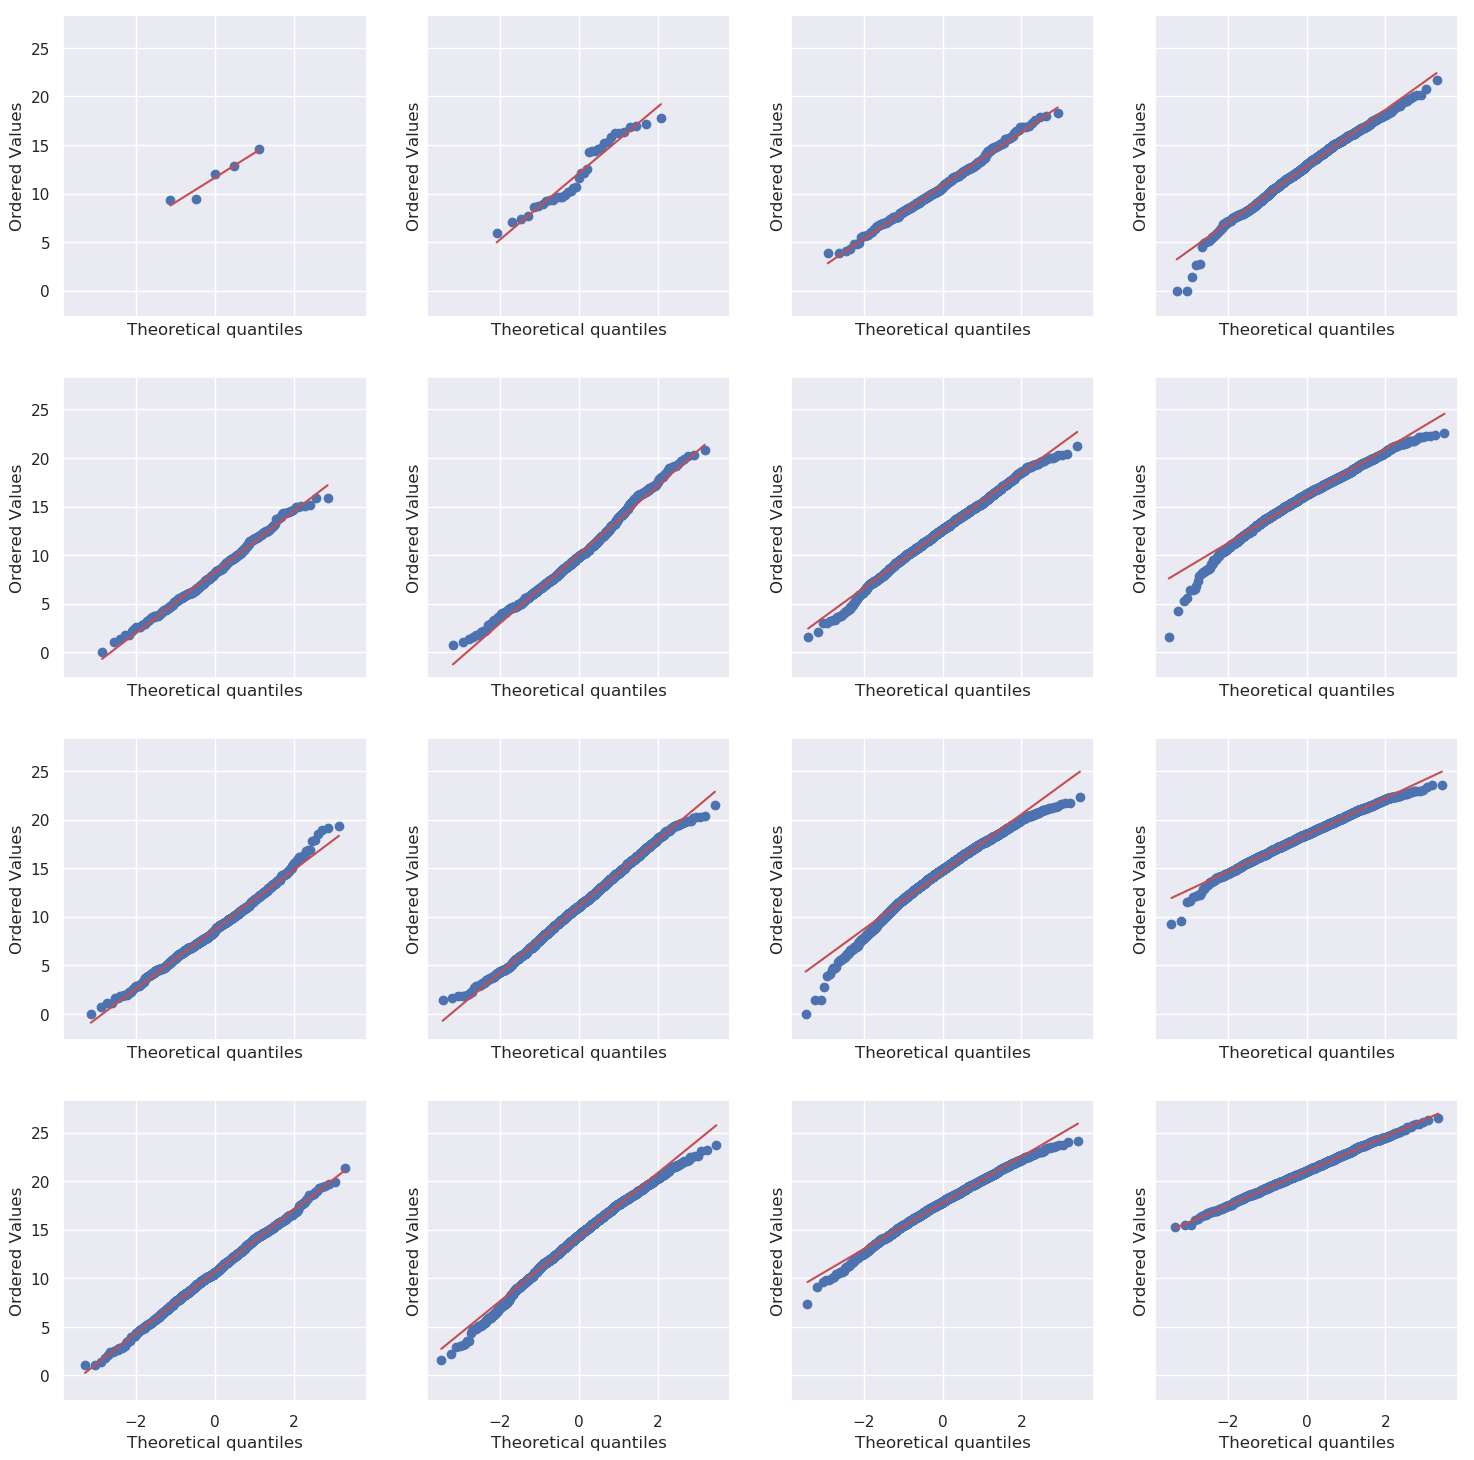

In [40]:
fig, axs = plt.subplots(num_ne, num_ne, figsize=(18,18), sharey=True, sharex=True)
for i in range(num_ne):
    for j in range(num_ne):
        A_ = A[classes==i,:][:,classes==j]
        #axs[i,j] = fig.add_subplot(num_ne, num_ne, 1+i*num_ne+j)
        x = A_[A_>0].flatten().log()
        if x.sum()>0:
            stats.probplot(x, dist="norm", plot=axs[i,j])
            axs[i,j].set_title('')
#plt.savefig('../examples/images/wt_probplot_wdcsbm.pdf')
plt.show()

The estimations produced by WDCSBM seem to be the most convinient. It groups countries into 4 classes by the size of their economy and their trade.